In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing

import gradient
import dataset
import computations
import layer
#from layer import Linear, Softmax, Gradient
import network

import datetime
import time

In [2]:
np.random.seed(400)
np.seterr(over='raise');
plt.rcParams['figure.figsize'] = (15.0, 5.0)

In [3]:
network1 = network.Network()
cifar = dataset.CIFAR_IMAGES()
#asgn1.test_batch_images(cifar_batch1)

In [4]:
#### Exercise - 1 ###
# Read in the data & initialize the parameters of the network

filePathLocal_labels = 'Dataset/batches.meta'
filePathLocal_batch = 'Dataset/data_batch_1'
filePathLocal_data_TRAIN = 'Dataset/data_batch_1'
filePathLocal_data_VALIDATION = 'Dataset/data_batch_2'
filePathLocal_data_TEST = 'Dataset/test_batch'

filePathList = (filePathLocal_data_TRAIN, filePathLocal_data_VALIDATION, filePathLocal_data_TEST)

# Read TRAIN, VALIDATION, TEST data into numpy arrays (numpy.ndarray) from local files
network1.ReadData(cifar, filePathList)
# X = (d, N), Y = (K, N), y = (N,)   # N=number of total images in X
# X = (3072, 10000), Y = (10, 10000), y = (10000,)

# Find the MEAN and STD of trainX and broadcast them for matrix calculations
# trainX_Broadcast_MeanStd = (mean_train_X_broadcast, std_train_X_broadcast)
trainX_Broadcast_MeanStd = network1.MeanStd_Train_X(network1.train_X)

# Transform the INPUT to have zero mean ** Check that one if we need to transform all of them separately or
# only having the normalization as in here??
# Normalize all INPUT data by using MEAN and STD of TRAIN DATA
# OR should we normalize each of them using their own MEAN and STD ** selected that one
# NORMALIZE by using TRAINING DATA
train_X_Norm = network1.NormalizeData(network1.train_X, trainX_Broadcast_MeanStd)
#validation_X_Norm = network1.NormalizeData(network1.validation_X, trainX_Broadcast_MeanStd)
# NORMALIZE by using VALIDATION DATA
validation_X_Norm = network1.NormalizeData_Per_DataSet(network1.validation_X)
#test_X_Norm = network1.NormalizeData(network1.test_X, trainX_Broadcast_MeanStd)
# NORMALIZE by using TEST DATA
test_X_Norm = network1.NormalizeData_Per_DataSet(network1.test_X)

# mu = 0; d = network1.train_X.shape[0]; m = 50; K = network1.train_Y.shape[0]
# we will use only 20 of 3072 to have a dimension reduction in comparing grad_analytic and grad_Numerical
mu = 0; d = 20; m = 50; K = network1.train_Y.shape[0]

initial_sizes = (mu, d, m, K)

#sigma1 = 1 / int(np.sqrt(d))
sigma1 = 1 / np.sqrt(d)
sigma2 = 1 / np.sqrt(m)

# Generate W1, W2, b1, b2 matrices with initial values
#(W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K, sigma1, sigma2)
(W1, W2, b1, b2) = network1.Initialize_W_b(initial_sizes, sigma1, sigma2)
# W1 = (m, d),     W2 = (K, m),    b1 = (m, 1),   b2 = (K, 1)
# W1 = (50, 3072), W2 = (10, 50),  b1 = (50, 1),  b2 = (10, 1) # if we use the whole dimensions/features
# W1 = (50, 20),   W2 = (10, 50),  b1 = (50, 1),  b2 = (10, 1) # if we use 20 dimensions/features

In [5]:
'''
print("Mean-STD:\n trainX_Broadcast_MeanStd[0]=\n{}\n\ntrainX_Broadcast_MeanStd[1]=\n{}".\
      format(trainX_Broadcast_MeanStd[0], trainX_Broadcast_MeanStd[1]))
print("\n\nMean-STD:\n train_X_Norm.mean(axis=1)={}\n\n".format(train_X_Norm.mean(axis=1)))
'''
print("Shape check:\n train_X_Norm={}\t validation_X_Norm={}\t test_X_Norm={}".format(train_X_Norm.shape, validation_X_Norm.shape, test_X_Norm.shape))
print(" train_Y={}\t\t validation_Y={}\t\t test_Y={}".format(network1.train_Y.shape, network1.validation_Y.shape, network1.test_Y.shape))
print(" train_y={}\t\t validation_y={}\t\t\t test_y={}".format(network1.train_y.shape, network1.validation_y.shape, network1.test_y.shape))
print(" W1={}\t\t\t W2={}\t\t\t\t b1={}\t\t\t b2={}".format(W1.shape, W2.shape, b1.shape, b2.shape))

Shape check:
 train_X_Norm=(3072, 10000)	 validation_X_Norm=(3072, 10000)	 test_X_Norm=(3072, 10000)
 train_Y=(10, 10000)		 validation_Y=(10, 10000)		 test_Y=(10, 10000)
 train_y=(10000,)		 validation_y=(10000,)			 test_y=(10000,)
 W1=(50, 20)			 W2=(10, 50)				 b1=(50, 1)			 b2=(10, 1)


In [6]:
#### Exercise - 2 ###
# Compute the gradients for the network parameters

# only 20 features are used for gradient-TEST calculations and 
# 2 images only not the whole batch (10k images)
# X_batch = train_X_Norm[0:d, :]                 # if we would like to test with the entire batch
# num_image = number of images to use in gradient comparison calculations 
num_image = 2
X_batch = train_X_Norm[0:d, 0:num_image]
Y_batch = network1.train_Y[:, 0:num_image]
y_batch = network1.train_y[0:num_image]

linearLayer1 = layer.Linear()
reluLayer = layer.ReLU()             # not an exact layer but operational step..
linearLayer2 = layer.Linear()
softmaxLayer = layer.Softmax()       # not an exact layer but operational step..

layers = [linearLayer1, reluLayer, linearLayer2, softmaxLayer]

'''
S1 = linearLayer1.Forward(X_batch, W1, b1)
# h = X(layer_no) ... X(0)=represents the input
H = ReLUlayer.Forward(S1)
S = linearLayer1.Forward(H, W2, b2)
P = softmaxLayer.Forward(S)
'''
W = [W1, W2]
b = [b1, b2]

P, H = network1.EvaluationClassifier(layers, X_batch, W, b)


In [7]:
#### Exercise - 2 ###
# let's test the same process with a loop. this time, in the loop, one layer's output will be 
# the input of the following layer
num_image = 2
X_batch = train_X_Norm[0:d, 0:num_image]
Y_batch = network1.train_Y[:, 0:num_image]
y_batch = network1.train_y[0:num_image]

linearLayer1 = layer.Linear()
reluLayer = layer.ReLU()             # not an exact layer but operational step..
linearLayer2 = layer.Linear()
softmaxLayer = layer.Softmax() 

layers = [linearLayer1, reluLayer, linearLayer2, softmaxLayer]

W = [W1, W2]
b = [b1, b2]


P, H = network1.EvaluationClassifier_loop(layers, X_batch, W, b)

In [8]:
def GradientComparison_Analytical_Numerical(X, H, Y, lambda_cost = 0, h = 1e-5):
    grad = gradient.Gradient()
    G = -np.subtract(Y, P) # only for 2 images (change num_image value if you want to use different # of images)
    N = Y_batch.shape[1]
    
    (grad_W2, grad_b2, G) = grad.ComputeGradients_Linear_HiddenLayer(N, G, H, lambda_cost, W2)
    #print('grad_W2.shape={}'.format(grad_W2.shape))
    #print('grad_b2.shape={}'.format(grad_b2.shape))
    
    G = reluLayer.Backward(G, H)
    N = H.shape[1]
    
    (grad_W1, grad_b1) = grad.ComputeGradients_Linear_FirstLayer(N, G, X_batch, lambda_cost, W1)
    
    start_time = datetime.datetime.now()

    W = [W1, W2]
    b = [b1, b2]
    #X_all = [X_batch, H]
    #(grad_W_num, grad_b_num) = grad.ComputeGradsNumSlow(layers, X_batch, Y_batch, W, b, lambda_cost, h=1e-5)
    (grad_W_num, grad_b_num) = grad.ComputeGradsNumSlow(X, Y, W, b, lambda_cost, h)

    grad_W1_num = grad_W_num[0]
    grad_W2_num = grad_W_num[1]

    grad_b1_num = grad_b_num[0]
    grad_b2_num = grad_b_num[1]

    end_time = datetime.datetime.now()

    print("Calculation time of GradsNumSlow: " + str(end_time - start_time))
    
    print('\n\n***** grad_W1, grad_W1_num')
    grad.CompareGradients_W(grad_W1, grad_W1_num)
    
    print('\n\n***** grad_W2, grad_W2_num')
    grad.CompareGradients_W(grad_W2, grad_W2_num)
    
    print('\n\n***** grad_b1, grad_b1_num')
    grad.CompareGradients_b(grad_b1, grad_b1_num)
    
    print('\n\n***** grad_b2, grad_b2_num')
    grad.CompareGradients_b(grad_b2, grad_b2_num)
    

In [9]:
# takes less than a second
GradientComparison_Analytical_Numerical(X_batch, H, Y_batch, lambda_cost = 0, h = 1e-5)

Calculation time of GradsNumSlow: 0:00:00.282604


***** grad_W1, grad_W1_num

grad_W_difference_MEAN = 7.448042807619361e-12
grad_W_difference_MIN = 0.0
grad_W_difference_MAX = 4.180217977323153e-11

grad_W_MIN = 0.0
grad_W_num_MIN = 0.0
grad_W_MAX = 0.263187266439426
grad_W_num_MAX = 0.26318726642493573


***** grad_W2, grad_W2_num

grad_W_difference_MEAN = 7.532225861799947e-12
grad_W_difference_MIN = 0.0
grad_W_difference_MAX = 4.598055269866563e-11

grad_W_MIN = 0.0
grad_W_num_MIN = 0.0
grad_W_MAX = 0.6481946016209915
grad_W_num_MAX = 0.648194601637897


***** grad_b1, grad_b1_num

grad_b_difference_MEAN = 8.697536371671256e-12
grad_b_difference_MIN = 0.0
grad_b_difference_MAX = 2.8872293444948127e-11

grad_b_MIN = 0.0
grad_b_num_MIN = [0.]

grad_b_MAX = 0.2321359378763498
grad_b_num_MAX = [0.23213594]


***** grad_b2, grad_b2_num

grad_b_difference_MEAN = 1.3584279534573085e-11
grad_b_difference_MIN = 1.8527263057066534e-12
grad_b_difference_MAX = 3.675354465215719e-11

grad_b_MI

In [10]:
def GradientSanityCheck(network1, train_X_Norm):
    n_epocs = 200    # number of times we will iterate on the entire data (10K images in our case)
    batch_size = 100    # the size of the mini-batch. in other words, number of images in 1 mini-batch.
    eta = 0.001      # learning rate (step-size)
    lambda_cost = 0  # regularization coefficient (punishment)
    #d = train_X_Norm.shape[0]
    d = 3072
    m = 50           # number of nodes in the hidden layer
    K = network1.train_Y.shape[0]  # number of classes

    # Generate W1, W2, b1, b2 matrices with initial values
    # (W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K)
    sigma1 = 1 / int(np.sqrt(d))
    sigma2 = 1 / np.sqrt(m)
    #(W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K, sigma1, sigma2)
    initial_sizes = [0, d, m, K]
    (W1, W2, b1, b2) = network1.Initialize_W_b(initial_sizes, sigma1, sigma2)

    W = [W1, W2]
    b = [b1, b2]

    J_epocs_train = np.zeros(n_epocs)         # cost array     - will keep costs per epoc (iteration)
    Accuracy_epocs_train = np.zeros(n_epocs)  # accuracy array - will keep accuracy per epoc (iteration)

    linearLayer1 = layer.Linear()
    reluLayer = layer.ReLU()             # not an exact layer but operational step..
    linearLayer2 = layer.Linear()
    softmaxLayer = layer.Softmax()       # not an exact layer but operational step..
    ReLUlayer = layer.ReLU()
    grad = gradient.Gradient()

    layers = [linearLayer1, reluLayer, linearLayer2, softmaxLayer]
    # total_batch = how many mini-batches will we need to cover the entire training set?
    #total_batch = int(train_X_normalized.shape[1] / batch_size)
    #n_sanity_batch = 1
    # we will only use 100 images for sanity check that means there will be only 1 mini-batch
    n_sanity_batch = 1
    n_test_images = batch_size * n_sanity_batch

    start_time = datetime.datetime.now()
    for e in range(n_epocs):
        for batch in range(n_sanity_batch):
            index_list = list(range(batch * batch_size, (batch + 1) * batch_size))
            # shuffling is not necessary but good to have
            #np.random.shuffle(index_list)
            #X_batch = train_X_Norm[:, index_list]
            X_batch = train_X_Norm[0:d, index_list]
            Y_batch = network1.train_Y[:, index_list]

            P, H = network1.EvaluationClassifier(layers, X_batch, W, b)

            G2 = -np.subtract(network1.train_Y[:, index_list], P)
            N2 = Y_batch.shape[1] #N

            # N, G
            (grad_W2, grad_b2, G1) = grad.ComputeGradients_Linear_HiddenLayer(N2, G2, H, lambda_cost, W2) 
            G0 = reluLayer.Backward(G1, H)
            N1 = H.shape[1] #N
            # N, G
            (grad_W1, grad_b1) = grad.ComputeGradients_Linear_FirstLayer(N1, G0, X_batch, lambda_cost, W1)

            W1 = W1 - eta * grad_W1
            W2 = W2 - eta * grad_W2

            #W1 = Wstar1
            #W2 = Wstar2

            bstar_m1 = b1 - eta * grad_b1
            b1 = bstar_m1[:, :1]
            #b1 = bstar1

            bstar_m2 = b2 - eta * grad_b2
            b2 = bstar_m2[:, :1]
            #b2 = bstar2

        W = [W1, W2]
        b = [b1, b2]

        #J_train = network1.Cost(X_batch, Y_batch, W, b, lambda_cost)
        #J_train = network1.Cost(train_X_Norm[:, 0:], Y_batch, W, b, lambda_cost)
        #J_train = network1.Cost(train_X_Norm[:, :batch*total_batch], network1.train_y[index_list],\
         #                       W, b, lambda_cost)
        J_train = network1.Cost(train_X_Norm[0:d, 0:n_test_images], network1.train_Y[:, 0:n_test_images],\
                                W, b, lambda_cost)

        J_epocs_train[e] = J_train

        #P_train = self.EvaluationClassifier(train_X_normalized, W, b)
        #k_train = np.argmax(P, axis=0)

        P, H = network1.EvaluationClassifier(layers, train_X_Norm[0:d, 0:n_test_images], W, b)
        k_train = np.argmax(P, axis=0)

        A_train = network1.ComputeAccuracy(k_train, network1.train_y[0:n_test_images])
        Accuracy_epocs_train[e] = A_train

        #self.Plot_Train_Validation_Cost_Accurracy(J_epocs_train, Accuracy_epocs_train)

    end_time = datetime.datetime.now()
    
    print("Calculation time of GradientSanityCheck: " + str(end_time - start_time))
    ## d = 20,   N=100    >>> Cost from 2.54  to 2.38    >>> Accuracy from 0.08 to 0.15    >> time: 0.15 seconds
    ## d = 3072, N=100    >>> Cost from 2.439 to 1.199   >>> Accuracy from 0.15 to 0.74    >> time: 1.23 seconds
    ## d = 3072, N=10000  >>> Cost from 2.347 to 1.323   >>> Accuracy from 0.1906 to 0.543 >> time: 3.08 minutes
        
    print(J_epocs_train)
    print(Accuracy_epocs_train)
    
    Plot_Train_Cost_Accurracy(J_epocs_train, Accuracy_epocs_train)

In [11]:
def Plot_Train_Cost_Accurracy(J_epocs_train, Accuracy_epocs_train):
        plt.subplot(1,2,1)
        plt.plot(J_epocs_train, 'g-', label='J_epocs_train')
        plt.title('J_epocs_train')
        plt.xlabel('n_epochs')
        plt.ylabel('J_epocs_train')
        plt.legend()
        plt.grid('on')
        
        plt.subplot(1,2,2)
        plt.plot(Accuracy_epocs_train, 'r-', label='Accuracy_epocs_train')
        plt.title('Accuracy_epocs_train')
        plt.xlabel('n_epochs')
        plt.ylabel('Accuracy_epocs_train')
        plt.legend()
        plt.grid('on')

Calculation time of GradientSanityCheck: 0:00:01.140827
[2.38141841 2.36450693 2.34802706 2.33194751 2.31618708 2.30089071
 2.28588608 2.27091724 2.25622107 2.24157926 2.22699612 2.2126453
 2.19846949 2.18458225 2.17115511 2.15809151 2.14531877 2.13276476
 2.12052738 2.10864204 2.09704919 2.08555144 2.07424372 2.06321992
 2.05218869 2.04139736 2.03080174 2.0204127  2.01013614 2.00001399
 1.99006018 1.98020556 1.97045738 1.9608275  1.95132739 1.94191467
 1.93270478 1.92361452 1.91469319 1.90590944 1.89718644 1.88857539
 1.88003341 1.87158506 1.86323861 1.85496985 1.84682741 1.83875007
 1.83076322 1.82286238 1.81504002 1.80733752 1.79967122 1.79208482
 1.78451646 1.77705237 1.76962499 1.76226563 1.75497114 1.74765122
 1.74041076 1.73319945 1.72608571 1.71903342 1.71205125 1.70508384
 1.69808495 1.69118195 1.68434652 1.67760025 1.6709648  1.66440851
 1.6578919  1.65145517 1.64509149 1.63876215 1.63247444 1.62626872
 1.62017265 1.61407749 1.60807326 1.60208982 1.59617654 1.59030353
 1.5845

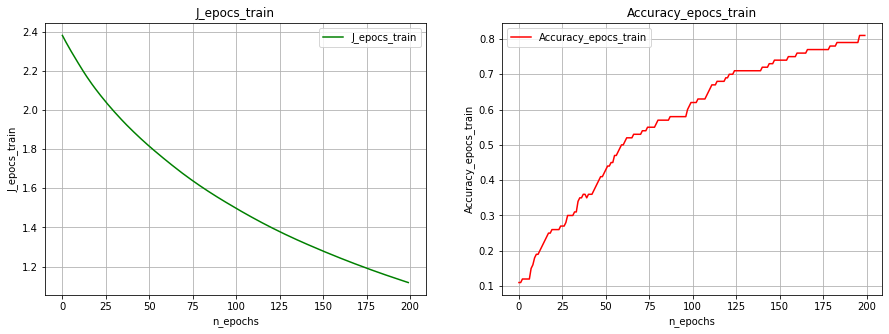

In [12]:
# takes 2 seconds
GradientSanityCheck(network1, train_X_Norm)

In [13]:
def Vanilla_MiniBacth_GD(network1, train_X_Norm):
    # GradientSanityCheck_FullTraining(network1, train_X_Norm)
    # This one is called "Vanilla mini-batch gradient descent"
    n_epocs = 200    # number of times we will iterate on the entire data (10K images in our case)
    batch_size = 100    # the size of a mini-batch. in other words, number of images in 1 mini-batch.
    eta = 0.001      # learning rate (step-size)
    #eta = 0.001     # MEL: If I use an eta bigger than 1e-3, I receive an overflow error for SOFTMAX
    lambda_cost = 0  # regularization coefficient (punishment)
    #lambda_cost = 0.01
    d = train_X_Norm.shape[0]
    m = 50 
    K = network1.train_Y.shape[0]  # number of classes

    # Generate W1, W2, b1, b2 matrices with initial values
    # (W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K)
    sigma1 = 1 / int(np.sqrt(d))
    sigma2 = 1 / np.sqrt(m)
    #(W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K, sigma1, sigma2)
    initial_sizes = [0, d, m, K]
    (W1, W2, b1, b2) = network1.Initialize_W_b(initial_sizes, sigma1, sigma2)

    W = [W1, W2]
    b = [b1, b2]

    J_epocs_train = np.zeros(n_epocs)         # cost array     - will keep costs per epoc (iteration)
    Accuracy_epocs_train = np.zeros(n_epocs)  # accuracy array - will keep accuracy per epoc (iteration)

    linearLayer1 = layer.Linear()
    reluLayer = layer.ReLU()             # not an exact layer but operational step..
    linearLayer2 = layer.Linear()
    softmaxLayer = layer.Softmax()       # not an exact layer but operational step..
    ReLUlayer = layer.ReLU()
    grad = gradient.Gradient()

    layers = [linearLayer1, reluLayer, linearLayer2, softmaxLayer]
    # total_batch = how many mini-batches will we need to cover the entire training set?
    total_batch = int(train_X_Norm.shape[1] / batch_size)
    #n_sanity_batch = 1
    # we will only use 100 images for sanity check that means there will be only 1 mini-batch
    #n_sanity_batch = 1
    #n_test_images = batch_size * n_sanity_batch

    start_time = datetime.datetime.now()
    for e in range(n_epocs):
        for batch in range(total_batch):
            index_list = list(range(batch * batch_size, (batch + 1) * batch_size))
            # shuffling is not necessary but good to have
            #np.random.shuffle(index_list)
            #X_batch = train_X_Norm[:, index_list]
            X_batch = train_X_Norm[:, index_list]
            Y_batch = network1.train_Y[:, index_list]

            P, H = network1.EvaluationClassifier(layers, X_batch, W, b)

            G2 = -np.subtract(network1.train_Y[:, index_list], P)  # G
            N2 = Y_batch.shape[1] #N

            # N, G
            (grad_W2, grad_b2, G1) = grad.ComputeGradients_Linear_HiddenLayer(N2, G2, H, lambda_cost, W2) 
            G0 = reluLayer.Backward(G1, H)
            N1 = H.shape[1] #N
            # N, G
            (grad_W1, grad_b1) = grad.ComputeGradients_Linear_FirstLayer(N1, G0, X_batch, lambda_cost, W1)

            # W1star, W2star
            W1 = W1 - eta * grad_W1
            W2 = W2 - eta * grad_W2

            # b1star, b2star
            bstar_m1 = b1 - eta * grad_b1
            b1 = bstar_m1[:, :1]  # there's a broadcast issue needs to be fixed, that's why we pick only 1 column

            bstar_m2 = b2 - eta * grad_b2
            b2 = bstar_m2[:, :1]  # broadcast issue, this is a quick workaround - use 1 column

        W = [W1, W2]
        b = [b1, b2]

        J_train = network1.Cost(train_X_Norm, network1.train_Y, W, b, lambda_cost)

        J_epocs_train[e] = J_train

        P, H = network1.EvaluationClassifier(layers, train_X_Norm, W, b)
        k_train = np.argmax(P, axis=0)

        A_train = network1.ComputeAccuracy(k_train, network1.train_y)
        Accuracy_epocs_train[e] = A_train

        #self.Plot_Train_Validation_Cost_Accurracy(J_epocs_train, Accuracy_epocs_train)

    end_time = datetime.datetime.now()
    
    print("Calculation time of GradientSanityCheck: " + str(end_time - start_time))
        
    print(J_epocs_train)
    print(Accuracy_epocs_train)

In [14]:
#GradientSanityCheck_FullTraining(network1, train_X_Norm)
# takes around 3-3.5 minutes
Vanilla_MiniBacth_GD(network1, train_X_Norm)

Calculation time of GradientSanityCheck: 0:03:02.023809
[2.22799015 2.27064244 2.4520189  3.14684817 2.60470707 2.40477466
 2.16056023 2.11753492 2.15546103 2.21632305 2.13731107 2.04741237
 1.93581681 1.86861164 1.82401917 1.81911749 1.79649215 1.76987219
 1.75516484 1.74479231 1.7532359  1.76821934 1.76079228 1.72981642
 1.70511877 1.69049981 1.68224735 1.6796235  1.67076782 1.66707202
 1.65842817 1.65348078 1.64515917 1.63966521 1.63320274 1.62901528
 1.62523961 1.62268987 1.62187167 1.62013767 1.62130716 1.62033927
 1.617709   1.6124351  1.60391631 1.59500496 1.58477652 1.57682676
 1.56834903 1.56267671 1.55585043 1.55172019 1.54641864 1.54351545
 1.53966646 1.5392158  1.53870426 1.54062236 1.54395728 1.54485049
 1.54871393 1.54264392 1.53819469 1.53021933 1.52306363 1.51802995
 1.51288988 1.51011819 1.50489087 1.50306641 1.49840728 1.49735075
 1.49259763 1.49129901 1.48688049 1.48434576 1.47969212 1.47578124
 1.47163702 1.46748457 1.46403305 1.45959272 1.45681042 1.4526378
 1.4508

In [15]:
#def Plot_Train_Validation_Cost_Accurracy(self, Cost_Train, Cost_Validation, Acc_Train, Acc_Validation):
def Plot_Train_Validation_Cost_Accurracy(Cost_Train, Cost_Validation, Acc_Train, Acc_Validation, Eta):
        plt.subplot(1,3,1)
        plt.plot(Cost_Train, 'g-', label='Train')
        plt.plot(Cost_Validation, 'r-', label='Validation')
        plt.title('Cost Comparison')
        plt.xlabel('n_records')
        plt.ylabel('Cost')
        plt.legend()
        plt.grid('on')
        
        plt.subplot(1,3,2)
        plt.plot(Acc_Train, 'g-', label='Train')
        plt.plot(Acc_Validation, 'r-', label='Validation')
        plt.title('Accuracy Comparison')
        plt.xlabel('n_records')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid('on')
        
        plt.subplot(1,3,3)
        plt.plot(Eta, 'g-', label='Eta')
        plt.title('Eta Change')
        plt.xlabel('Time')
        plt.ylabel('Eta')
        plt.legend()
        plt.grid('on')

In [17]:
# this function uses the FULL training data to calculate the ACCURACY & COST
def Train_Cyclical(param_list, cost_calculation_method = 'Batch_aggregated'):
    # param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, 
    #               record_per_cycle, m, eta_min, eta_max, n_steps]
    '''
    Up until now, we have trained our networks with Vanilla mini-batch gradient descent. 
    To help speed up training times and avoid time-consuming searches for good values of eta, we will now
    implement mini-batch-GD training where the learning rate at each update step is defined in a cylical way
    check equations (14) and (15) in the assignment.
    '''
    network1 = param_list[0]
    train_X_Norm = param_list[1]        # 45.000 images
    validation_X_Norm = param_list[2]   # 5.000 images
    # the size of a mini-batch. in other words, number of images in 1 mini-batch
    batch_size = param_list[3]          # 100
    # number of triangles that you want to use to test different eta values
    n_cycles = param_list[4]            # 1
    # regularization coefficient (punishment)
    lambda_cost = param_list[5]         # 0.01
    # how many calculations do you want to see per cycle? = 10? 20? 30? to plot the graph
    # record_per_cycle = 100  (+1 is to show the first calculation, as well)
    record_per_cycle = param_list[6]
 
    d = train_X_Norm.shape[0]           # dimension of X_train... 3072 = 32 x 32 x 3
    m = param_list[7]                   # number of nodes in the hidden layer... 50
    K = network1.train_Y.shape[0]       # number of classes... 10
    eta_min = param_list[8]             # learning rate (step-size)   i.e. 1e-5 
    eta_max = param_list[9]             # learning rate (step-size)   i.e. 1e-1 
    # n_s = k * np.floor(n/n_batch) by definition in the assignment
    # so, k corresponds to the number of epochs to complete a half cycle, for a full-cycle,
    # we need to run the calculations 2*k times. i.e. if k=5, we need 10 epochs
    n_steps = param_list[10]            # number of steps to complete a half cycle(triangle)

    # Generate W1, W2, b1, b2 matrices with initial values
    # (W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K)
    sigma1 = 1 / int(np.sqrt(d))
    sigma2 = 1 / np.sqrt(m)
    #(W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K, sigma1, sigma2)
    initial_sizes = [0, d, m, K]
    (W1, W2, b1, b2) = network1.Initialize_W_b(initial_sizes, sigma1, sigma2)

    W = [W1, W2]
    b = [b1, b2]

    linearLayer1 = layer.Linear()
    reluLayer = layer.ReLU()             # not an exact layer but operational step..
    linearLayer2 = layer.Linear()
    softmaxLayer = layer.Softmax()       # not an exact layer but operational step..
    ReLUlayer = layer.ReLU()
    grad = gradient.Gradient()

    layers = [linearLayer1, reluLayer, linearLayer2, softmaxLayer]
    # total_batch = how many mini-batches will we need to cover the entire training set?
    total_batch = int(np.floor(train_X_Norm.shape[1] / batch_size))
    
    # A full cycle once go up (from eta_min to eta_max) and once go down (from eta_max to eta_min)
    # so we multiply by 2
    #n_cycles = 1   # corresponds to "L array" in 2.L.ns in the assignment .. 
    # L=the current cycle number ... n_cycles=the total number of cycles to be applied
    # so L is an element of n_cycle >> i.e. L = {0, 1, 2, 3} if n_cycles = 4 
    # n_epocs=10 for 1 full cycle having n_steps=500 and batch_size=100
    # n_s = k * np.floor(n/n_batch) by definition in the assignment.. see the previous explanation above for n_steps
    n_epochs = int(2 * n_cycles * (n_steps / total_batch))
    #n_sanity_batch = 1
    # we will only use 100 images for sanity check that means there will be only 1 mini-batch
    #n_sanity_batch = 1
    #n_test_images = batch_size * n_sanity_batch
     
    n_records = total_batch * n_epochs         # number of batches will be used IN TOTAL for ALL calculations
    # i.e. 450 * 4 = 1800
    
    # how many points in total we will have in the COST graph
    cost_record = record_per_cycle * n_cycles + 1  # 100 * 1 + 1 = 101
    ###comparison_number = total_batch/cost_record  
    # to be able to have that many points, at which batch we should run the COST functions (e.g. in every 18 batch)
    comparison_number = int(n_records / (cost_record - 1))  # 1800/100 = 18
    
    eta_train = np.zeros(n_records)              # we will check if we properly make a triangle
    
    J_epocs_train = np.zeros(cost_record)        # cost array to plot and see how cost changes
    Accuracy_epocs_train = np.zeros(cost_record) # accuracy array
    J_epocs_validation = np.zeros(cost_record) 
    Accuracy_epocs_validation = np.zeros(cost_record)
    
    
    #print('batch_size: {}, lambda_cost : {}, d: {}, m: {}, K: {}'.format(batch_size, lambda_cost, d, m, K))
    ##print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}, cost_record: {}'.format(total_batch, n_steps, n_epochs, n_records, cost_record))
    #print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}'.format(total_batch, n_steps, n_epochs, 
     #                                                                           n_records))
    #print('\nrecord_per_cycle: {}, cost_record : {}, comparison_number: {}'.format(record_per_cycle, cost_record, 
      #                                                                             comparison_number))
  
    # cycleID in use.. if n_cycles=0 then cycle max will be 0. else it will be incremented by 1 at each 2*n_steps
    cycle_no = 0
    J_train_sum = 0
    n_records = 0       # this will basically show the number of batches processed until now
    list_params = []
    smooth_cost = 0
    cost_record = 0
    # step number in the current cycle, it resets with a new cycle. 
    cycle_step = 0   # just to see where we are in the current triangle
    
    start_time = datetime.datetime.now()
    for e in range(n_epochs):
        for batch in range(total_batch):
            index_list = list(range(batch * batch_size, (batch + 1) * batch_size))
            # shuffling is not necessary but good to have
            np.random.shuffle(index_list)
            X_batch = train_X_Norm[:, index_list]
            Y_batch = network1.train_Y[:, index_list]

            P, H = network1.EvaluationClassifier(layers, X_batch, W, b)

            G2 = -np.subtract(network1.train_Y[:, index_list], P)
            N2 = Y_batch.shape[1]

            (grad_W2, grad_b2, G1) = grad.ComputeGradients_Linear_HiddenLayer(N2, G2, H, lambda_cost, W2) 
            G0 = reluLayer.Backward(G1, H)
            N1 = H.shape[1]

            (grad_W1, grad_b1) = grad.ComputeGradients_Linear_FirstLayer(N1, G0, X_batch, lambda_cost, W1)
            
            # n_cycles = 1   # corresponds to "L array" in 2.L.ns in the assignment .. 
            # L=the current cycle number ... n_cycles=the total number of cycles to be applied
            # so L is an element of n_cycle >> i.e. L = {0, 1, 2, 3} if n_cycles = 4 
            #if 2*cycle_no*n_steps <= t and t <= (2*cycle_no+1)*n_steps:
            # n_records corresponds to t in the formula
            if 2*cycle_no*n_steps <= n_records and n_records <= (2*cycle_no+1)*n_steps:
                #eta = eta_min + (t - 2*cycle_no*n_steps)/n_steps*(eta_max-eta_min)
                eta = eta_min + (n_records - 2*cycle_no*n_steps)/n_steps*(eta_max-eta_min)
            #elif (2*cycle_no+1)*n_steps <= t and t <= 2*(cycle_no+1)*n_steps:
            elif (2*cycle_no+1)*n_steps <= n_records and n_records <= 2*(cycle_no+1)*n_steps:
                #eta = eta_max - (t - (2*cycle_no+1)*n_steps)/n_steps*(eta_max-eta_min)
                eta = eta_max - (n_records - (2*cycle_no+1)*n_steps)/n_steps*(eta_max-eta_min)
            
            eta_train[n_records] = eta
            
            # W1star, W2star
            W1 = W1 - eta * grad_W1
            W2 = W2 - eta * grad_W2

            # b1star, b2star
            bstar_m1 = b1 - eta * grad_b1
            b1 = bstar_m1[:, :1]  # there's a broadcast issue needs to be fixed, that's why we pick only 1 column

            bstar_m2 = b2 - eta * grad_b2
            b2 = bstar_m2[:, :1]  # broadcast issue, this is a quick workaround - use 1 column
            
            W = [W1, W2]
            b = [b1, b2]

            #if n_records % 10 == 0:
            if n_records == 0 or (n_records + 1) % comparison_number == 0:
                #print('\nepoch: {}, batch: {}, n_records: {}, cycle_step: {}'.format(e, batch, n_records, cycle_step))

                if cost_calculation_method == 'ALL_Data':
                    J_train = network1.Cost(train_X_Norm, network1.train_Y, W, b, lambda_cost)
                    J_epocs_train[cost_record] = J_train

                    P, H = network1.EvaluationClassifier(layers, train_X_Norm, W, b)
                    k_train = np.argmax(P, axis=0)
                    A_train = network1.ComputeAccuracy(k_train, network1.train_y)
                    Accuracy_epocs_train[cost_record] = A_train           

                    J_validation = network1.Cost(validation_X_Norm , network1.validation_Y, W, b, lambda_cost)
                    J_epocs_validation[cost_record] = J_validation

                    P_val, H_val = network1.EvaluationClassifier(layers, validation_X_Norm, W, b)
                    k_validation = np.argmax(P_val, axis=0)
                    A_validation = network1.ComputeAccuracy(k_validation, network1.validation_y)
                    Accuracy_epocs_validation[cost_record] = A_validation
                    
                elif cost_calculation_method == 'Batch_aggregated':
                    J_train = network1.Cost(X_batch, Y_batch, W, b, lambda_cost)
                    J_train_sum += J_train
                    smooth_cost = J_train_sum/(cost_record + 1)
                    #J_epocs_train[n_records] = J_train
                    J_epocs_train[cost_record] = smooth_cost

                    ## If we use the ALL TRAINING data to calculate the training accuracy:
                    # it feels like better to use that one
                    P, H = network1.EvaluationClassifier(layers, train_X_Norm, W, b)
                    k_train = np.argmax(P, axis=0)
                    A_train = network1.ComputeAccuracy(k_train, network1.train_y)
                    Accuracy_epocs_train[cost_record] = A_train

                    J_validation = network1.Cost(validation_X_Norm , network1.validation_Y, W, b, lambda_cost)
                    J_epocs_validation[cost_record] = J_validation

                    P_val, H_val = network1.EvaluationClassifier(layers, validation_X_Norm, W, b)
                    k_validation = np.argmax(P_val, axis=0)
                    A_validation = network1.ComputeAccuracy(k_validation, network1.validation_y)
                    Accuracy_epocs_validation[cost_record] = A_validation
                    
                elif cost_calculation_method == 'Batch_aggregated_ratio':
                    J_train = network1.Cost(X_batch, Y_batch, W, b, lambda_cost)
                    if n_records == 0:
                        smooth_cost = J_train
                    else:
                        #smooth_cost = 0.999*smooth_cost + 0.001 * J_train
                        smooth_cost = 0.99*smooth_cost + 0.01 * J_train
                    #J_epocs_train[n_records] = J_train
                    J_epocs_train[cost_record] = smooth_cost

                    ## If we use the ALL TRAINING data to calculate the training accuracy:
                    # it feels like better to use that one
                    P, H = network1.EvaluationClassifier(layers, train_X_Norm, W, b)
                    k_train = np.argmax(P, axis=0)
                    A_train = network1.ComputeAccuracy(k_train, network1.train_y)
                    Accuracy_epocs_train[cost_record] = A_train

                    J_validation = network1.Cost(validation_X_Norm , network1.validation_Y, W, b, lambda_cost)
                    J_epocs_validation[cost_record] = J_validation

                    P_val, H_val = network1.EvaluationClassifier(layers, validation_X_Norm, W, b)
                    k_validation = np.argmax(P_val, axis=0)
                    A_validation = network1.ComputeAccuracy(k_validation, network1.validation_y)
                    Accuracy_epocs_validation[cost_record] = A_validation
                    
                cost_record += 1        
                
                #print('cycle_no: {} ... eta: {} ... time: {}'.format(cycle_no, eta, datetime.datetime.now()))
                #print('J_train: {} ... smooth_cost : {} ... J_validation: {}'.format(J_train, smooth_cost, J_validation))

            
            n_records += 1
            cycle_step += 1
            
            if n_records % (2 * n_steps) == 0:
                cycle_no += 1
                cycle_step = 0

    end_time = datetime.datetime.now()
    
    #print("Calculation time of Train_Cyclical: " + str(end_time - start_time))
    #print("x-axis (steps) must be multiplied by 10 since the values recorded once in every 10 Cycle")
    
    Plot_Train_Validation_Cost_Accurracy(J_epocs_train, J_epocs_validation, Accuracy_epocs_train, 
                                         Accuracy_epocs_validation, eta_train)
    #print('batch_size: {}, lambda_cost : {}, d: {}, m: {}, K: {}'.format(batch_size, lambda_cost, d, m, K))
    #print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}, cost_record: {}'.format(total_batch, n_steps, n_epochs, n_records, cost_record))
    #print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}'.format(total_batch, n_steps, 
     #                                                                           n_epochs, n_records))
    #print('\nrecord_per_cycle: {}, cost_record : {}, comparison_number: {}'.format(record_per_cycle, 
      #                                                                             cost_record, comparison_number))
    return layers, W, b, eta_train
    
    

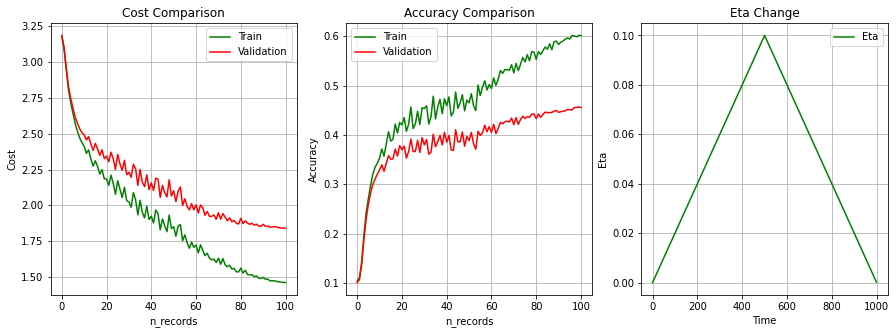

In [18]:
#### Exercise - 3 ###
# takes around 2.5 minutes
# TRAIN = VALIDATION = TEST = 10.000
# Train_Cyclical(network1, train_X_Norm, validation_X_Norm, n_cycles, n_steps)
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, 0.01, 100, 50, 1e-5, 1e-1, 500]
layers1, W1, b1, eta_train = Train_Cyclical(param_list, 'ALL_Data')


In [19]:
P_test, H_test = network1.EvaluationClassifier(layers1, test_X_Norm, W1, b1)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.454


In [20]:
print('Eta_Train\nmin: {}\tmax: {}\tmean: {}\tmedian: {}\nstd: {}\tvar: {}'.format(min(eta_train), 
        max(eta_train), np.mean(eta_train), np.median(eta_train), np.std(eta_train), np.var(eta_train)))

Eta_Train
min: 1e-05	max: 0.1	mean: 0.050004999999999994	median: 0.05000500000000001
std: 0.02886474216641126	var: 0.0008331733403334001


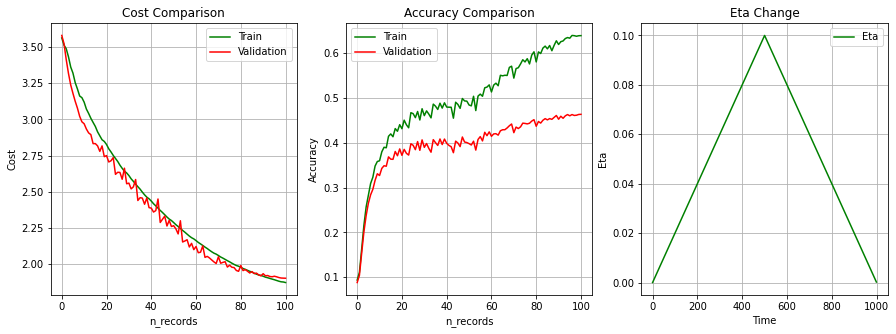

In [21]:
#### Exercise - 3 ###
# takes around 1.5 minutes
# TRAIN = VALIDATION = TEST = 10.000
# Train_Cyclical(network1, train_X_Norm, validation_X_Norm, n_cycles, n_steps)
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, 0.01, 100, 100, 1e-5, 1e-1, 500]
layers1, W1, b1, eta_train = Train_Cyclical(param_list, 'Batch_aggregated')

In [22]:
P_test, H_test = network1.EvaluationClassifier(layers1, test_X_Norm, W1, b1)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4736


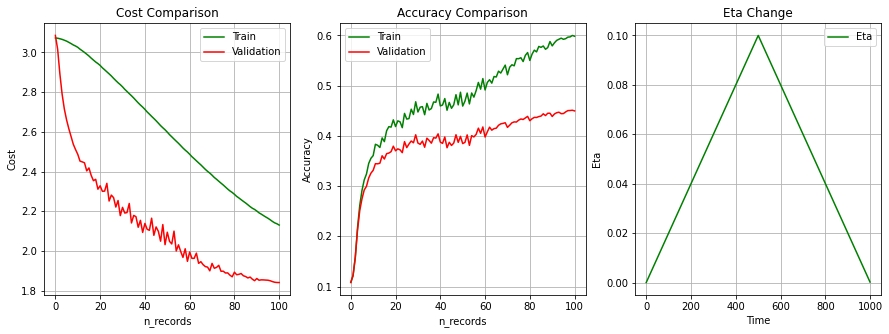

In [23]:
#### Exercise - 3 ###
# takes around 1.5 minutes
# TRAIN = VALIDATION = TEST = 10.000
# Train_Cyclical(network1, train_X_Norm, validation_X_Norm, n_cycles, n_steps)
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, 0.01, 100, 50, 1e-5, 1e-1, 500]
layers1, W1, b1, eta_train = Train_Cyclical(param_list, 'Batch_aggregated_ratio')

In [24]:
P_test, H_test = network1.EvaluationClassifier(layers1, test_X_Norm, W1, b1)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4574


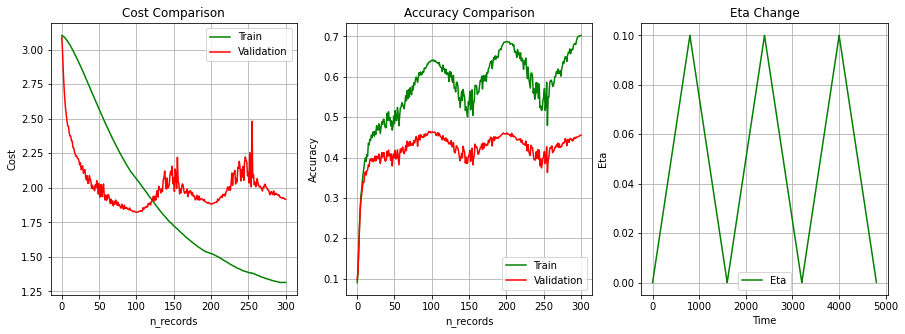

In [25]:
# takes around 4.5 minutes
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, 0.01, 100, 50, 1e-5, 1e-1, 800]
layers2, W2, b2, eta_train = Train_Cyclical(param_list, 'Batch_aggregated_ratio')

In [26]:
P_test, H_test = network1.EvaluationClassifier(layers2, test_X_Norm, W2, b2)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4652


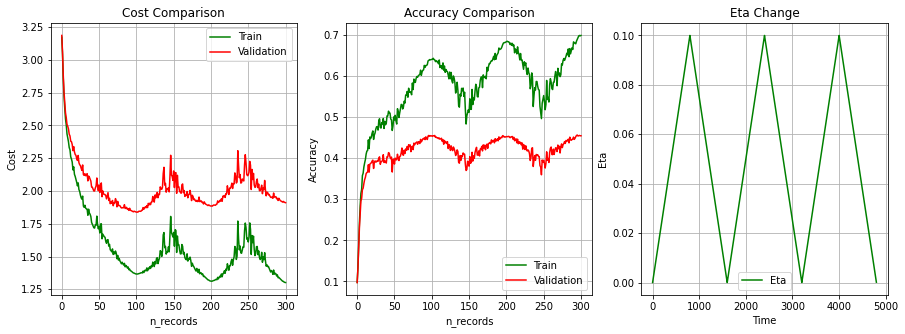

In [27]:
# takes around 8.5 minutes
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, 0.01, 100, 50, 1e-5, 1e-1, 800]
layers2, W2, b2, eta_train = Train_Cyclical(param_list, 'ALL_Data')

In [28]:
P_test, H_test = network1.EvaluationClassifier(layers2, test_X_Norm, W2, b2)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4576


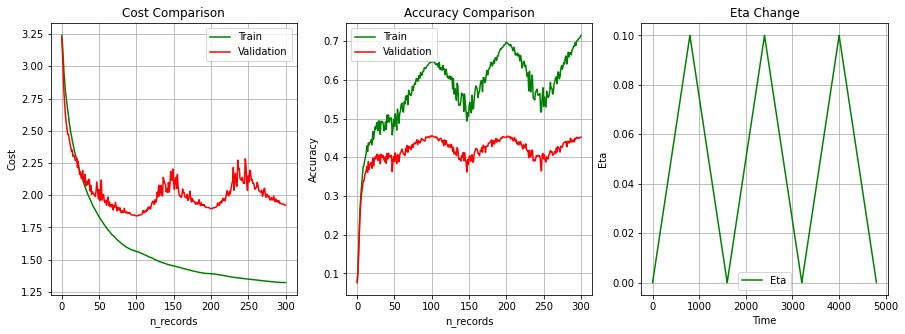

In [29]:
# takes around 4.5 minutes
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, 0.01, 100, 50, 1e-5, 1e-1, 800]
layers2, W2, b2, eta_train = Train_Cyclical(param_list, 'Batch_aggregated')

In [30]:
P_test, H_test = network1.EvaluationClassifier(layers2, test_X_Norm, W2, b2)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4653


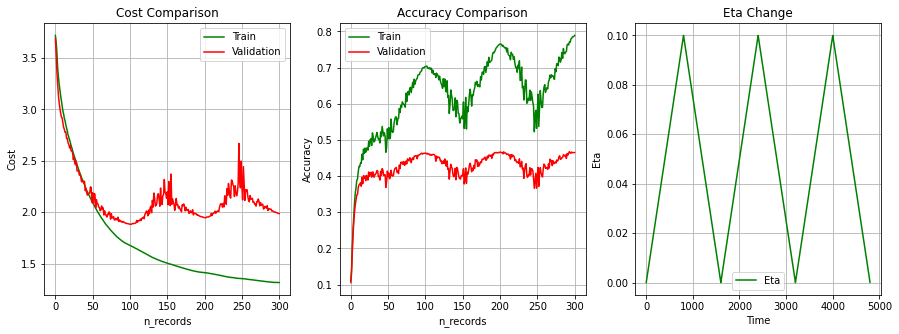

In [31]:
# takes around 4 minutes 45 seconds
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max, n_steps]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, 0.01, 100, 100, 1e-5, 1e-1, 800]
layers2, W2, b2, eta_train = Train_Cyclical(param_list, 'Batch_aggregated')

In [32]:
P_test, H_test = network1.EvaluationClassifier(layers2, test_X_Norm, W2, b2)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4781
